In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


import time
from tqdm import tqdm
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier


import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples


from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report


from xgboost import XGBRFClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Load Data

In [2]:
import zipfile
with zipfile.ZipFile("pump_sensor.zip","r") as zip_ref:
    zip_ref.extractall("")

In [3]:
df = pd.read_csv('pump_sensor.csv')
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [4]:
df.shape

(220320, 55)

## Finding the missing value

In [5]:
# Find any missign values in any column
# Result will be sum of missing values in each column

df.isnull().sum()

Unnamed: 0             0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


We found that sensor_15 data is completely missing and sensor_50 data is missing around 40%

In [6]:
df.dtypes

Unnamed: 0          int64
timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36   

## Find Duplicate Values


In [7]:
# Find duplicate values based on timestamp
# Result will be list of duplicate values
# If no duolicate values nothing will list

#We found that there is no duplicate records

df[df['timestamp'].duplicated(keep=False)]

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status


## Label Data

In [8]:
df['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

The label data has 3 machine status values. BROKEN represents machine is failed. RECOVERING represents machine trying to recover from failed status. NORMAL represents the machine is working in normal status.


# Data Preprocessing


## Add Feature Time Period


In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [10]:
# Create a series
#time_period = pd.Series([])


# assign values to series
#for i in tqdm(range(df.shape[0])):
 #   if(df["timestamp"][i].hour >=4) and (df["timestamp"][i].hour <10):
  #      time_period[i]="Morning"
   # elif (df["timestamp"][i].hour >=10) and (df["timestamp"][i].hour <16):
    #    time_period[i]="Noon"
    #elif (df["timestamp"][i].hour >=16) and (df["timestamp"][i].hour <22):
     #   time_period[i]="Evening"
        
    #else:
     #   time_period[i]="Night"

In [11]:
# Insert new column time_period
#df.insert(2, "time_period", time_period)

In [12]:
df.to_csv('df1.csv', index=False)

In [13]:
df = pd.read_csv('df1.csv')

In [14]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [15]:
del df['Unnamed: 0']

In [16]:
# Entire "sensor_15" column is NaN therefore removing the entire column from the data set
del df['sensor_15']

The purpose of adding time_period is to find that any significance in pump failure with respect to time. We have divided 24 hrs into Morning, Noon, Evening and Night and trying to find at what time failure occurs most.

## Fill Missing Values


In [17]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [18]:
# Let's take a look at top ten columns with missing values
calc_percent_NAs(df).head(10)

,percent
sensor_50,0.349569
sensor_51,0.069821
sensor_00,0.046333
sensor_07,0.024741
sensor_08,0.023180
sensor_06,0.021777
sensor_09,0.020856
sensor_01,0.001675
sensor_30,0.001185
sensor_29,0.000327


In [19]:
# The columns sensor(00, 06, 07, 08, 09, 51)
# Missing values are filled with median value of respective columns

df['sensor_00'].fillna(df['sensor_00'].median(), inplace=True)
df['sensor_06'].fillna(df['sensor_06'].median(), inplace=True)
df['sensor_07'].fillna(df['sensor_07'].median(), inplace=True)
df['sensor_08'].fillna(df['sensor_08'].median(), inplace=True)
df['sensor_09'].fillna(df['sensor_09'].median(), inplace=True)
df['sensor_51'].fillna(df['sensor_51'].median(), inplace=True)

df['sensor_01'].fillna(df['sensor_01'].median(), inplace=True)
df['sensor_02'].fillna(df['sensor_02'].median(), inplace=True)
df['sensor_03'].fillna(df['sensor_03'].median(), inplace=True)
df['sensor_04'].fillna(df['sensor_04'].median(), inplace=True)
df['sensor_05'].fillna(df['sensor_05'].median(), inplace=True)
df['sensor_10'].fillna(df['sensor_10'].median(), inplace=True)

In [20]:
df= df.dropna()

In [21]:
df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [22]:
df.shape

(142883, 52)

In [23]:
# Let's take a look at top ten columns with missing values
calc_percent_NAs(df).head(10)

,percent


### Normalize Values
The purpose of normalization is to scale numeric data from different columns down to an equivalent scale. We are using StandardScaler normalization.'

StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.

### Encode Label
We replace the categorical value with a numeric value. The machine_status, NORMAL is mapped to 0, RECOVERING and BROKEN is mapped to 1.

In [24]:
# let's have a look at how many labels each variable has
print(len(df['machine_status'].unique()), ' labels')

3  labels


In [25]:
# let's have a look at how many labels each variable has
df['machine_status'].value_counts()

NORMAL        128480
RECOVERING     14397
BROKEN             6
Name: machine_status, dtype: int64

In [26]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["machine_status"] = lb_make.fit_transform(df["machine_status"])
df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,1
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,1
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,1


In [27]:
list(lb_make.inverse_transform([0, 1, 2]))

['BROKEN', 'NORMAL', 'RECOVERING']

In [28]:
scaler = StandardScaler()
df2 = df.drop(['machine_status'], axis=1)
names=df2.columns
X = df[names]
y = df.drop(df2.columns, axis=1)
scaled_predictors = scaler.fit_transform(X)
scaled_Target = scaler.fit_transform(y)

In [66]:
X.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889


In [65]:
# Write the dataframe to csv 
X.to_csv('X.csv')
y.to_csv('y.csv')

In [29]:
df.isna().sum()

sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0
sensor_50         0


### Correlation


<AxesSubplot:>

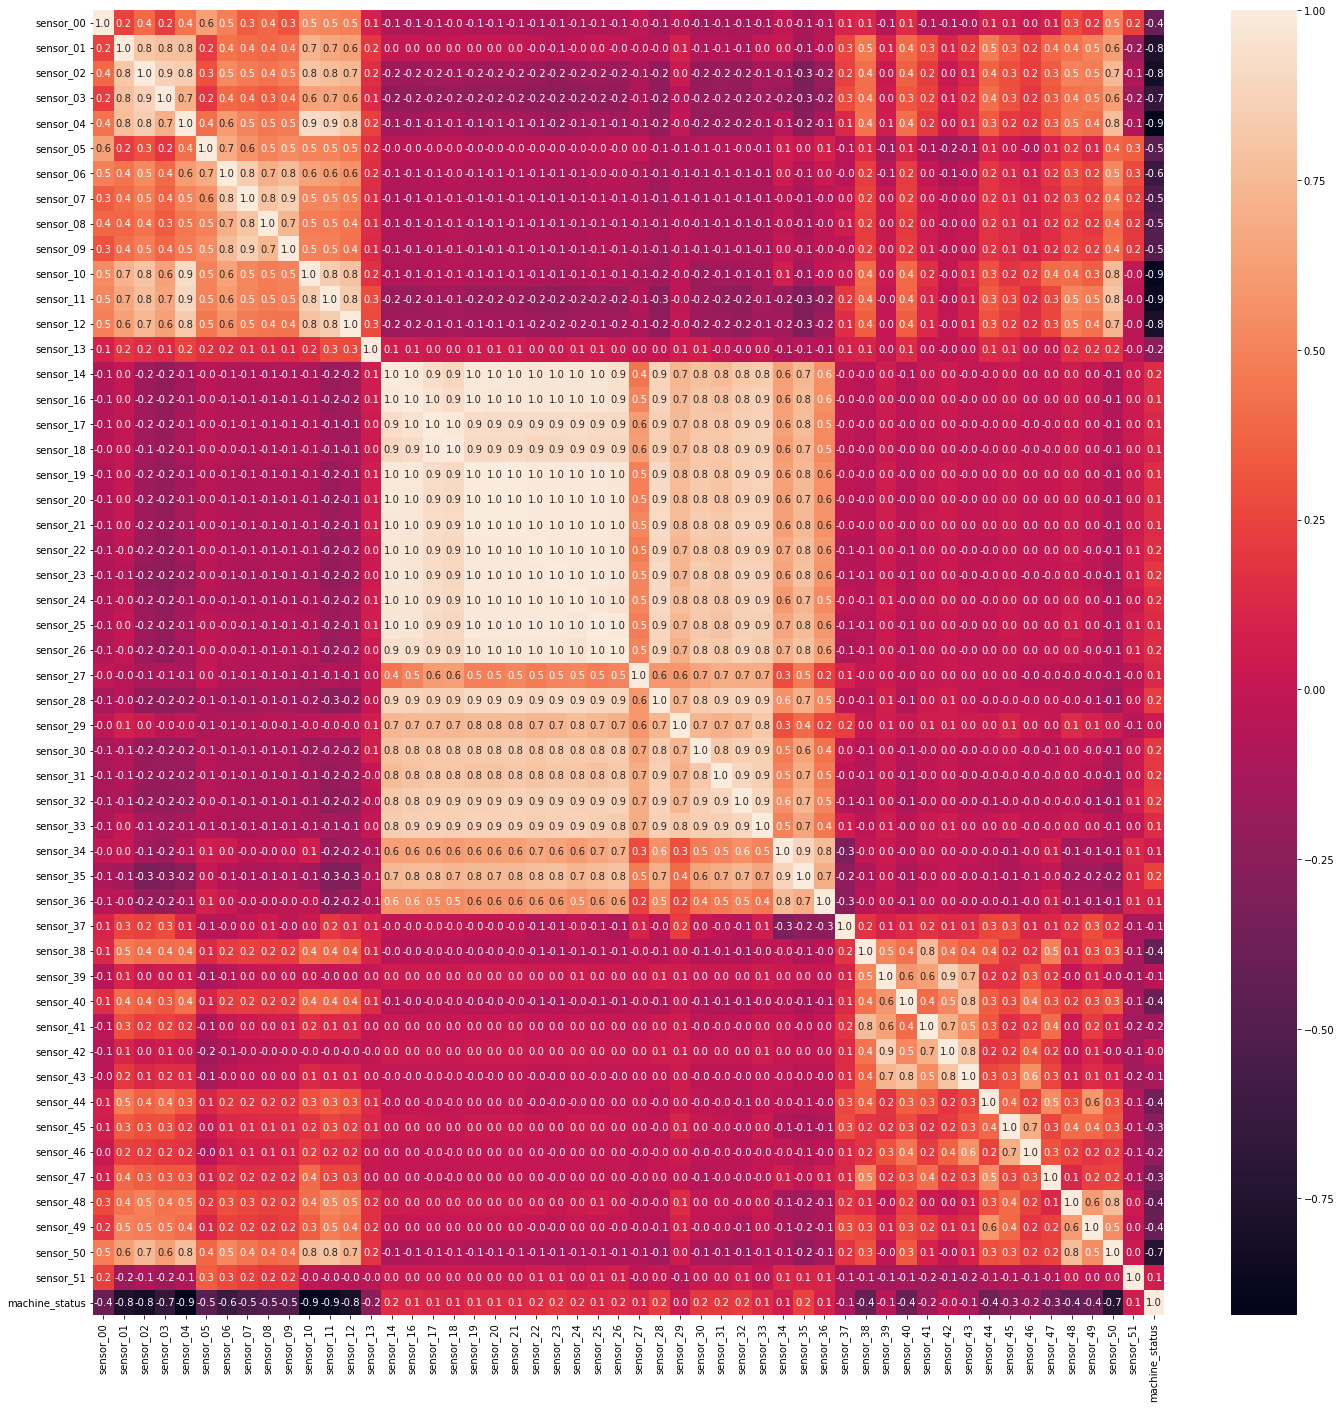

In [30]:
# Correlation is used to find relation between features
# The Value vasries from +1 to -1
# +1 means high positive correlation
# -1 means high negative correlation
# heatmap is a graphical representation of data using colors to visualize the value

corr = df.corr()
plt.figure(figsize=(24, 24))
sns.heatmap(corr, annot=True, fmt='.1f')

There is a strong correlation exists between sensor_14 to sensor_26, sensor_28 to sensor_33 and sensor_34 to sensor_36 data
The above mentioned data can be avoided for machine learning model otherwise performance will decrease.
machine_status highly positive correlated with sensor_01 to sensor_12 data
Here we are considering 0.5 and above sensor data which influences the machine_status.

### Feature Engineering


### Feature Importance
It uses ensembles of decision trees to compute the relative importance of each feature.
These importance values can be used to inform a feature selection process.

C:\Users\DATASC~1\AppData\Local\Temp/ipykernel_16252/1553650155.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


<AxesSubplot:>

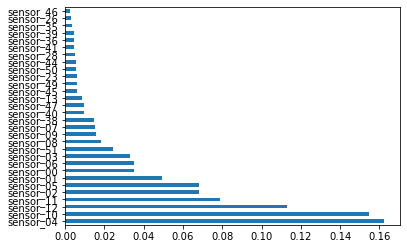

In [31]:
#Fit an extra trees model to the data
model = ExtraTreesClassifier()
model.fit(X, y)


# get importance
features = X
importances = model.feature_importances_
indices = np.argsort(importances)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
#Relative importAance of each feature
#print(model.feature_importances_)

In [32]:
#Final Features from Random Forest (Select Features with highest feature importance)
extra_tree_class_top_features = pd.DataFrame(feat_importances.nlargest(7)).axes[0].tolist()
extra_tree_class_top_features

['sensor_04',
 'sensor_10',
 'sensor_12',
 'sensor_11',
 'sensor_02',
 'sensor_05',
 'sensor_01']

In [33]:
#2.Select the top n features based on absolute correlation with target variable
corr_data1 = pd.concat([y,X],axis = 1)
corr_data = corr_data1.corr()
corr_data = corr_data.iloc[: , [0]]
corr_data.columns.values[0] = "Correlation"
corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()] 
corr_data = corr_data[corr_data['Correlation'].notna()]
corr_data = corr_data.loc[corr_data['Correlation'] != 1]
corr_data.tail(20)

,Correlation
sensor_47,-0.348140
sensor_44,-0.359163
sensor_49,-0.396550
sensor_00,-0.405293
sensor_40,-0.409825
sensor_38,-0.420385
sensor_48,-0.431726
sensor_05,-0.469455
sensor_08,-0.494891
sensor_09,-0.505852


In [34]:
#Select Features with greater than 80% absolute correlation
corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > .8]
corr_top_features = corr_data2.axes[0].tolist()

In [35]:
corr_top_features

['sensor_02', 'sensor_11', 'sensor_10', 'sensor_04']

In [36]:
#4.Perform recursive feature selection and use cross validation to identify the best number of features
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select= 7, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
rfe_feature

Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 21 features.
Fitting estimator with 11 features.


['sensor_00',
 'sensor_01',
 'sensor_02',
 'sensor_03',
 'sensor_06',
 'sensor_10',
 'sensor_18']

In [37]:
#5.Select the top n features based on absolute value of beta coefficients of features

# define standard scaler
scaler = StandardScaler()
# transform x data
scaled_predictors = scaler.fit_transform(X)
scaled_Target = scaler.fit_transform(y)

sr_reg = LinearRegression(fit_intercept = False).fit(scaled_predictors, scaled_Target)
coef_table = pd.DataFrame(list(X.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",sr_reg.coef_.transpose())
coef_table = coef_table.iloc[coef_table.Coefs.abs().argsort()] 


sr_data2 = coef_table.tail(10)
sr_top_features = sr_data2.iloc[:,0].tolist()
sr_top_features

['sensor_02',
 'sensor_21',
 'sensor_25',
 'sensor_00',
 'sensor_11',
 'sensor_14',
 'sensor_19',
 'sensor_10',
 'sensor_04',
 'sensor_23']

C:\Users\Data Scientist\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


<AxesSubplot:>

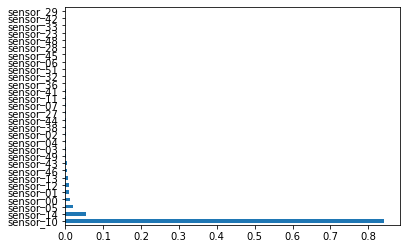

In [38]:
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier()
model.fit(X, y)


# get importance
features = X
importances = model.feature_importances_
indices = np.argsort(importances)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
#Relative importAance of each feature
#print(model.feature_importances_)

In [39]:
#Final Features from Random Forest (Select Features with highest feature importance)
xgb_top_features = pd.DataFrame(feat_importances.nlargest(7)).axes[0].tolist()
xgb_top_features

['sensor_10',
 'sensor_14',
 'sensor_05',
 'sensor_00',
 'sensor_01',
 'sensor_12',
 'sensor_13']

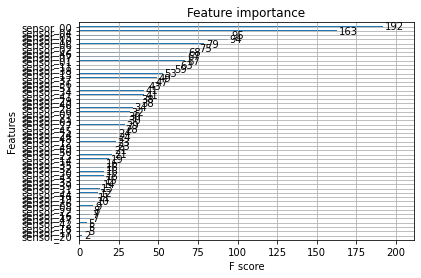

In [40]:
from matplotlib import pyplot

plot_importance(model)
pyplot.show()

In [41]:
from sktime.transformations.series.feature_selection import FeatureSelection

In [42]:
transformer = FeatureSelection(method="feature-importances", n_columns=7)
Xt = transformer.fit_transform(X, y)

C:\Users\Data Scientist\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [43]:
 Xt.columns.values

array(['sensor_10', 'sensor_05', 'sensor_14', 'sensor_00', 'sensor_01',
       'sensor_04', 'sensor_46'], dtype=object)

In [44]:
# Combining features from all the models

combined_feature_list = sr_top_features + corr_top_features + rfe_feature + xgb_top_features + extra_tree_class_top_features

combined_feature = {x:combined_feature_list.count(x) for x in combined_feature_list}
combined_feature_data = pd.DataFrame.from_dict(combined_feature,orient='index')

combined_feature_data.rename(columns={ combined_feature_data.columns[0]: "number_of_models" }, inplace = True)


combined_feature_data = combined_feature_data.sort_values(['number_of_models'], ascending=[False])

combined_feature_data.head(100)

,number_of_models
sensor_10,5
sensor_02,4
sensor_11,3
sensor_01,3
sensor_04,3
sensor_00,3
sensor_14,2
sensor_05,2
sensor_12,2
sensor_19,1


In [45]:
#Final Features: features which were selected in atleast 3 models

combined_feature_data = combined_feature_data.loc[combined_feature_data['number_of_models'] > 2]
final_features = combined_feature_data.axes[0].tolist()
final_features

['sensor_10', 'sensor_02', 'sensor_11', 'sensor_01', 'sensor_04', 'sensor_00']

In [46]:
# Final Master Data on Selected Features
features = X[X.columns.intersection(final_features)]
features_date =  df.iloc[1:,1]
features_final = features.set_index(features_date).asfreq('D')
features_final.head(10)

ValueError: Length mismatch: Expected 142883 rows, received array of length 142882

In [49]:
from pycaret.classification import *
exp_mclf101 = setup(data = df, target = 'machine_status', session_id=123, pca=True, feature_selection=True)

,Description,Value
0,session_id,123
1,Target,machine_status
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(142883, 52)"
5,Missing Values,False
6,Numeric Features,51
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [54]:
best_model = compare_models(sort = 'Accuracy', n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9991,0.0000,0.9660,0.9993,0.9994,0.9950,0.9950,1.4210
xgboost,Extreme Gradient Boosting,0.9989,0.0000,0.9659,0.9993,0.9993,0.9940,0.9940,5.9430
catboost,CatBoost Classifier,0.9989,0.0000,0.9658,0.9993,0.9993,0.9941,0.9941,10.2580
rf,Random Forest Classifier,0.9988,0.0000,0.9658,0.9992,0.9992,0.9932,0.9932,3.0250
knn,K Neighbors Classifier,0.9986,0.0000,0.9655,0.9993,0.9991,0.9924,0.9924,0.9190
lr,Logistic Regression,0.9897,0.0000,0.9582,0.9956,0.9938,0.9441,0.9443,5.5630
ridge,Ridge Classifier,0.9871,0.0000,0.9547,0.9968,0.9923,0.9319,0.9329,0.5540
svm,SVM - Linear Kernel,0.9861,0.0000,0.9583,0.9909,0.9917,0.9228,0.9232,1.0950
nb,Naive Bayes,0.9771,0.0000,0.9450,0.9947,0.9862,0.8824,0.8856,0.0270
dummy,Dummy Classifier,0.8988,0.0000,0.9333,0.8897,0.9371,0.0000,0.0000,0.5770


In [55]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9990,0.0000,0.9993,0.9996,0.9994,0.9945,0.9945
1,0.9987,0.0000,0.9991,0.9994,0.9993,0.9929,0.9929
2,0.9997,0.0000,0.9999,0.9998,0.9998,0.9984,0.9984
3,0.9996,0.0000,0.9999,0.9997,0.9998,0.9978,0.9978
4,0.9992,0.0000,0.9997,0.9994,0.9996,0.9956,0.9956
5,0.9990,0.0000,0.9996,0.9993,0.9994,0.9945,0.9945
6,0.9994,0.0000,1.0000,0.9993,0.9997,0.9967,0.9967
7,0.9979,0.0000,0.6630,0.9978,0.9979,0.9885,0.9885
8,0.9991,0.0000,0.9997,0.9993,0.9995,0.9950,0.9950
9,0.9993,0.0000,0.9998,0.9994,0.9996,0.9961,0.9961


In [56]:
tuned_et = tune_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9910,0.0000,0.9939,0.9961,0.9950,0.9510,0.9510
1,0.9896,0.0000,0.9942,0.9942,0.9942,0.9428,0.9428
2,0.9912,0.0000,0.9947,0.9955,0.9951,0.9518,0.9518
3,0.9893,0.0000,0.9935,0.9945,0.9940,0.9414,0.9414
4,0.9896,0.0000,0.9944,0.9940,0.9942,0.9427,0.9427
5,0.9901,0.0000,0.9935,0.9954,0.9945,0.9460,0.9460
6,0.9916,0.0000,0.9950,0.9957,0.9953,0.9539,0.9540
7,0.9906,0.0000,0.6498,0.9905,0.9906,0.9484,0.9484
8,0.9894,0.0000,0.9938,0.9944,0.9941,0.9418,0.9418
9,0.9916,0.0000,0.9949,0.9958,0.9953,0.9540,0.9540


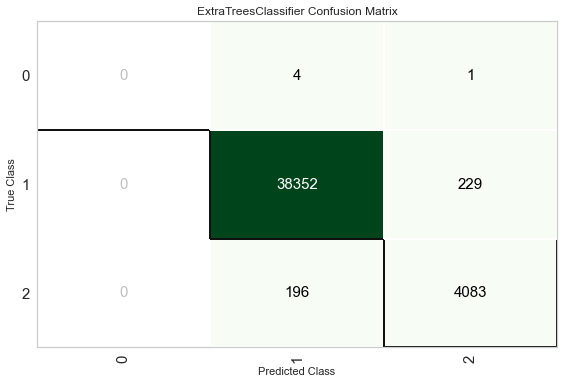

In [57]:
plot_model(tuned_et, plot = 'confusion_matrix')

In [59]:
xgboost = create_model('xgboost')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9985,0.0000,0.9990,0.9993,0.9992,0.9918,0.9918
1,0.9987,0.0000,0.9991,0.9994,0.9993,0.9929,0.9929
2,0.9992,0.0000,0.9996,0.9996,0.9996,0.9956,0.9956
3,0.9991,0.0000,0.9998,0.9992,0.9995,0.9950,0.9950
4,0.9992,0.0000,0.9997,0.9994,0.9996,0.9956,0.9956
5,0.9988,0.0000,0.9993,0.9993,0.9993,0.9934,0.9934
6,0.9995,0.0000,0.9999,0.9996,0.9997,0.9972,0.9972
7,0.9981,0.0000,0.6634,0.9980,0.9981,0.9896,0.9896
8,0.9989,0.0000,0.9993,0.9994,0.9994,0.9940,0.9940
9,0.9991,0.0000,0.9997,0.9993,0.9995,0.9950,0.9950


In [60]:
tuned_xgboost = tune_model(xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9893,0.0000,0.9934,0.9947,0.9940,0.9415,0.9415
1,0.9883,0.0000,0.9932,0.9938,0.9935,0.9358,0.9358
2,0.9899,0.0000,0.9944,0.9943,0.9944,0.9445,0.9445
3,0.9880,0.0000,0.9932,0.9934,0.9933,0.9341,0.9341
4,0.9891,0.0000,0.9944,0.9934,0.9939,0.9398,0.9399
5,0.9888,0.0000,0.9935,0.9940,0.9938,0.9385,0.9385
6,0.9906,0.0000,0.9953,0.9942,0.9948,0.9481,0.9481
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9879,0.0000,0.9935,0.9930,0.9933,0.9333,0.9333
9,0.9905,0.0000,0.9943,0.9951,0.9947,0.9479,0.9479


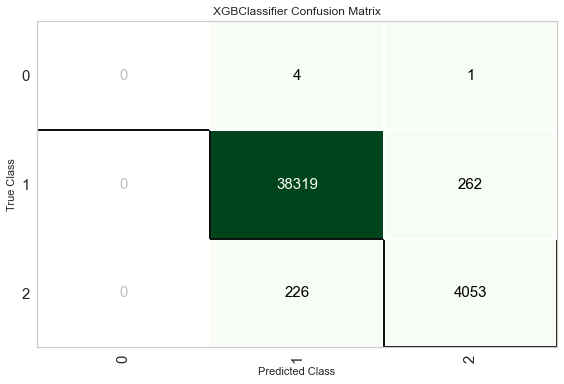

In [61]:
plot_model(tuned_xgboost, plot = 'confusion_matrix')

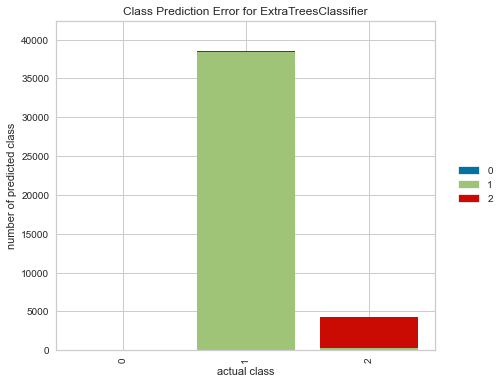

In [63]:
plot_model(tuned_et, plot = 'error')

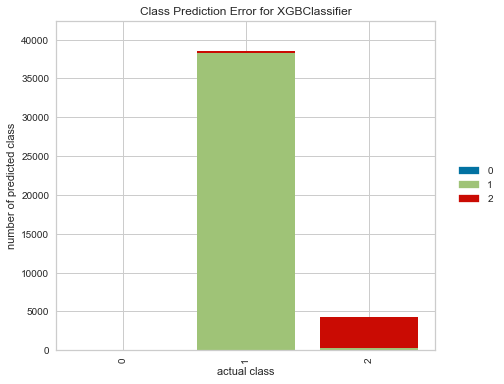

In [62]:
plot_model(tuned_xgboost, plot = 'error')

## KS Test

<AxesSubplot:xlabel='sensor_01', ylabel='Density'>

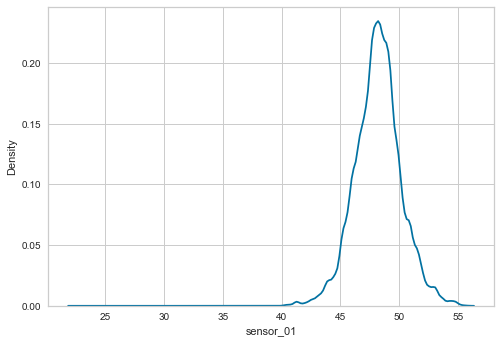

In [67]:
sns.set_style('whitegrid')
sns.kdeplot(data=df.loc[df['machine_status']==1], x='sensor_01')

<AxesSubplot:xlabel='sensor_01', ylabel='Density'>

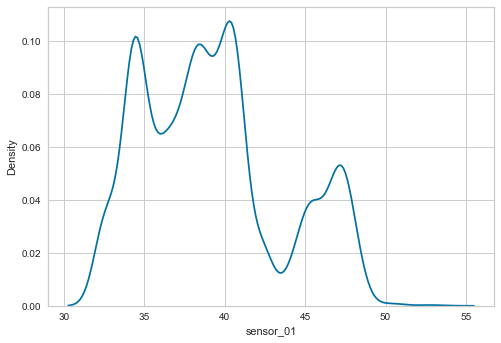

In [68]:
sns.set_style('whitegrid')
sns.kdeplot(data=df.loc[df['machine_status']==2], x='sensor_01')

In [69]:
stats.ks_2samp(df.loc[df['machine_status']==1]['sensor_01'], df.loc[df['machine_status']==2]['sensor_01'])

KstestResult(statistic=0.7990106537692793, pvalue=0.0)

* The first plot shows left tailed distribution for machine_status NORMAL
* The second plot shows non-uniform distributions for machine_status BROKEN
* statistic value how much close to 1 indicates two distributions are different
* p-value < 0.05 means reject the null hypothesis that the two samples were drawn from the same distribution
* Here it is shown for sensor_01 data like these other sensors data also need to be analyzed.

https://becominghuman.ai/predict-pump-failure-before-it-happens-using-deep-learning-model-dc886bfa073e